In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Cargar Datos y Arreglo de fechas

In [443]:
df_pr = pd.read_csv('datos/precip_cr2met_day.csv')
df_qq = pd.read_csv('datos/q_mm_day.csv')

In [444]:
df_pr.head()

,date,year,month,day,9414001
0,1979-01-01,1979,1,1,0.0
1,1979-01-02,1979,1,2,0.0
2,1979-01-03,1979,1,3,0.0
3,1979-01-04,1979,1,4,0.0
4,1979-01-05,1979,1,5,0.0


In [445]:
df_qq.head()

,date,9414001
0,1900-01-01,NaN
1,1900-01-02,NaN
2,1900-01-03,NaN
3,1900-01-04,NaN
4,1900-01-05,NaN


## Definiendo limites

In [446]:
date_serie = pd.date_range(start='1/01/1979', end='31/12/2018', freq='D')

/Users/lequi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [447]:
date_serie

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=14610, freq='D')

In [448]:
list(df_qq['date'])[0]

'1900-01-01'

In [449]:
str(date_serie[500])[:-9]

'1980-05-15'

In [450]:
start_date = '1979-01-01'
end_date = '2018-12-31'

In [451]:
list(df_qq['date']).index(start_date)

28854

In [452]:
list(df_qq['date']).index(end_date)

43463

In [453]:
date_qq = np.array(df_qq['date'][28854:43463+1])
qq = np.array(df_qq['9414001'][28854:43463+1])

In [454]:
list(df_pr['date']).index(end_date)

14609

In [455]:
date_pr = np.array(df_pr['date'][0:14609+1])
pr = np.array(df_pr['9414001'][0:14609+1])

In [456]:
print([len(pr), len(qq), len(date_serie)])

[14610, 14610, 14610]


No hay días faltantes

In [457]:
from tqdm import tqdm as tq

## Eliminacion de años bisiestos

In [458]:
date = []
qq_ = []
pr_ = []
for i in tq(range(0, len(date_serie))):
    if str(date_serie[i])[5:-9] != '02-29':
        qq_.append(qq[i])
        pr_.append(pr[i])
        date.append(date_serie[i])
    

100%|██████████████████████████████████| 14610/14610 [00:00<00:00, 78826.00it/s]


In [459]:
len(date)/365

40.0

In [460]:
df = pd.DataFrame({'date':date,
                  'pr': pr_,
                  'qq': qq_ })

len(df)

14600

# 1. Analisis armónico

In [461]:
qq_cicle = np.split(np.array(df['qq']), 40)
qq_cicle = np.array(qq_cicle).T

qq_cicle_mean = np.nanmean(qq_cicle, axis=1)


pr_cicle = np.split(np.array(df['pr']), 40)
pr_cicle = np.array(pr_cicle).T

pr_cicle_mean = np.nanmean(pr_cicle, axis=1)

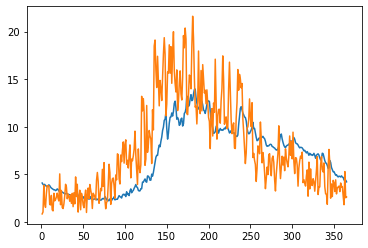

In [462]:
plt.plot(list(range(1, 366)), qq_cicle_mean)
plt.plot(list(range(1, 366)), pr_cicle_mean)

In [463]:
def armonico(x, T):
    return [np.cos((2.0*np.pi*x)/T), np.sin((2.0*np.pi*x)/T), 
            np.cos((2.0*np.pi*x)/(T/2)), np.sin((2.0*np.pi*x)/(T/2)),
            np.cos((2.0*np.pi*x)/(T/3)), np.sin((2.0*np.pi*x)/(T/3))]

In [464]:
from sklearn import linear_model

df.fillna(df.mean(), inplace=True) #Se reemplazaron datos faltantes con la media de la serie

y = df['qq']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 365)).T

regr_qq = linear_model.LinearRegression()
regr_qq.fit(X, y)

/var/folders/vm/k8dh5m_x4d15bk5cwzk1zk1r0000gn/T/ipykernel_50225/3560908053.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True) #Se reemplazaron datos faltantes con la media de la serie


LinearRegression()

In [465]:
qq_ = regr_qq.predict([armonico(x,365) for x in range(1,14601)])

In [466]:
y = df['pr']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 365)).T

regr_pr = linear_model.LinearRegression()
regr_pr.fit(X, y)

LinearRegression()

In [467]:
pr_ = regr_pr.predict([armonico(x,365) for x in range(1,14601)])

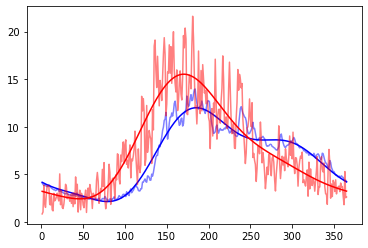

In [468]:
plt.plot(list(range(1, 366)), qq_cicle_mean, color = 'b', alpha=.5)
plt.plot(list(range(1, 366)), qq_[0:365], color = 'b')
plt.plot(list(range(1, 366)), pr_cicle_mean, color = 'r', alpha=.5)
plt.plot(list(range(1, 366)), pr_[0:365], color = 'r')

In [469]:
import matplotlib

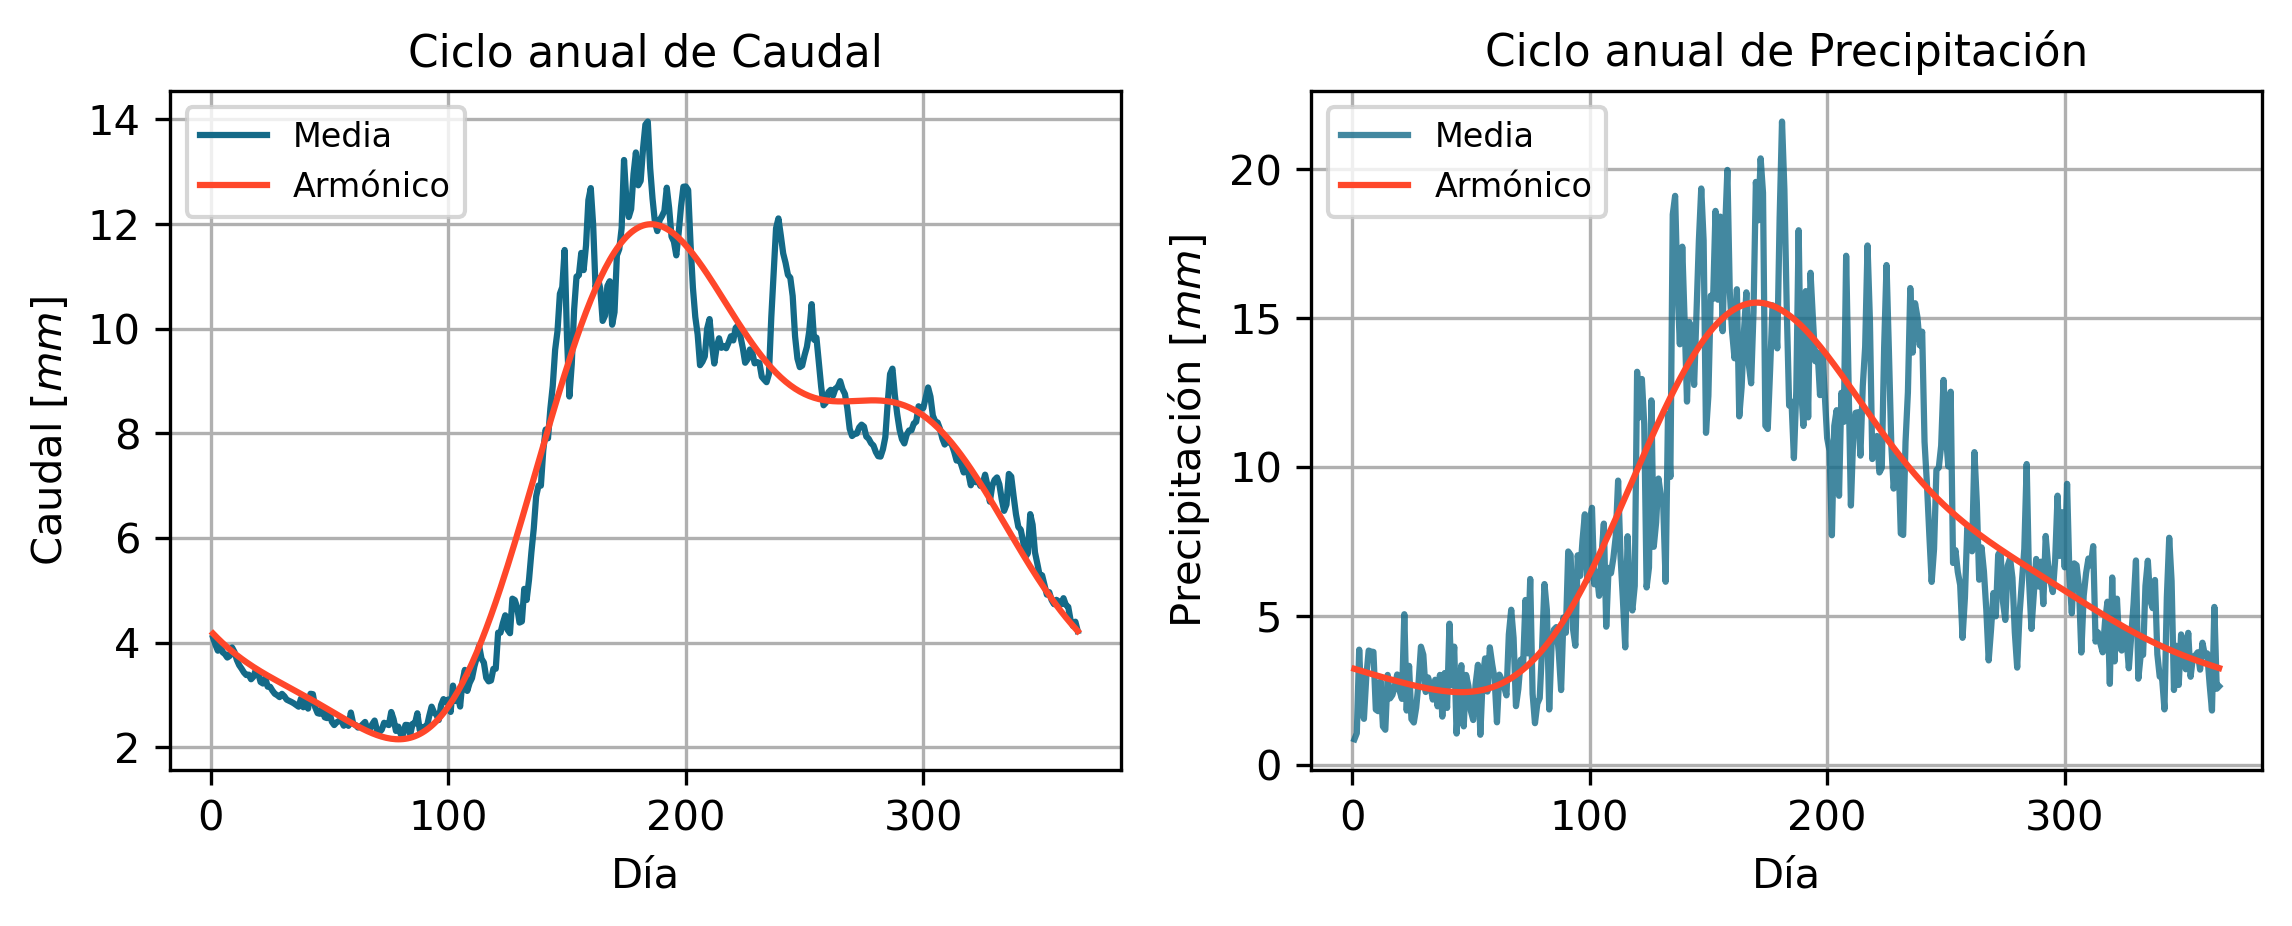

In [470]:
font = {'weight' : 'light',
        'size'   : 10}

matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (9,3) , dpi=300)

ax1.plot(list(range(1, 366)), qq_cicle_mean, color='#146a88', label='Media')
ax1.plot(list(range(1, 366)), qq_[0:365], color='#ff472a', label='Armónico')

ax1.set_ylabel('Caudal $[mm]$')
ax1.set_xlabel('Día')

ax1.legend(loc=2,prop={'size': 8})
ax1.grid()
ax1.set_title('Ciclo anual de Caudal', size=10.5)

ax2.plot(list(range(1, 366)), pr_cicle_mean, color='#146a88', alpha= 0.8, label='Media')
ax2.plot(list(range(1, 366)), pr_[0:365], color='#ff472a', label='Armónico')

ax2.set_ylabel('Precipitación $[mm]$')
ax2.set_xlabel('Día')

ax2.legend(loc=2,prop={'size': 8})
ax2.grid()
ax2.set_title('Ciclo anual de Precipitación', size=10.5)

plt.savefig('img/ciclos.pdf')

# 2. Analisis espectral

## Anomalias diarias

In [471]:
aqq = df['qq'].values -  qq_
apr = df['pr'].values - pr_

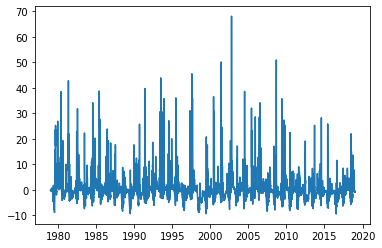

In [472]:
plt.plot(df['date'],aqq)

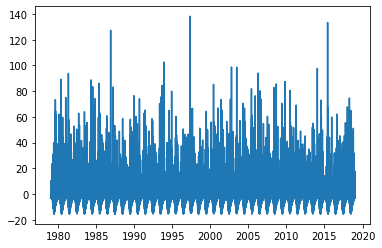

In [473]:
plt.plot(df['date'],apr)

## Espectro de anomalias

In [491]:
from numpy.fft import fft, ifft

In [492]:
m, b = np.polyfit(aqq[1:len(aqq)], aqq[0:len(aqq)-1], 1)
aqq_ar1 = m + b*aqq[1:len(aqq)]


m, b = np.polyfit(apr[1:len(apr)], aqq[0:len(apr)-1], 1)
apr_ar1 = m + b*apr[1:len(apr)]

In [493]:
X_qq = fft(aqq)

X_pr = fft(apr)

N = len(X_qq)
n = np.arange(N)
print(n)
# get the sampling rate
sr = 1 
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]
p_oneside = n[:n_oneside]

[    0     1     2 ... 14597 14598 14599]


In [495]:
t_d = 1/f_oneside


A_k_qq= np.abs(X_qq[:n_oneside])
C_k_qq= ((2/N)*(A_k_qq)**2)

A_k_pr= np.abs(X_pr[:n_oneside])
C_k_pr= ((2/N)*(A_k_pr)**2)


/var/folders/vm/k8dh5m_x4d15bk5cwzk1zk1r0000gn/T/ipykernel_50225/1841672540.py:1: RuntimeWarning: divide by zero encountered in true_divide
  t_d = 1/f_oneside


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


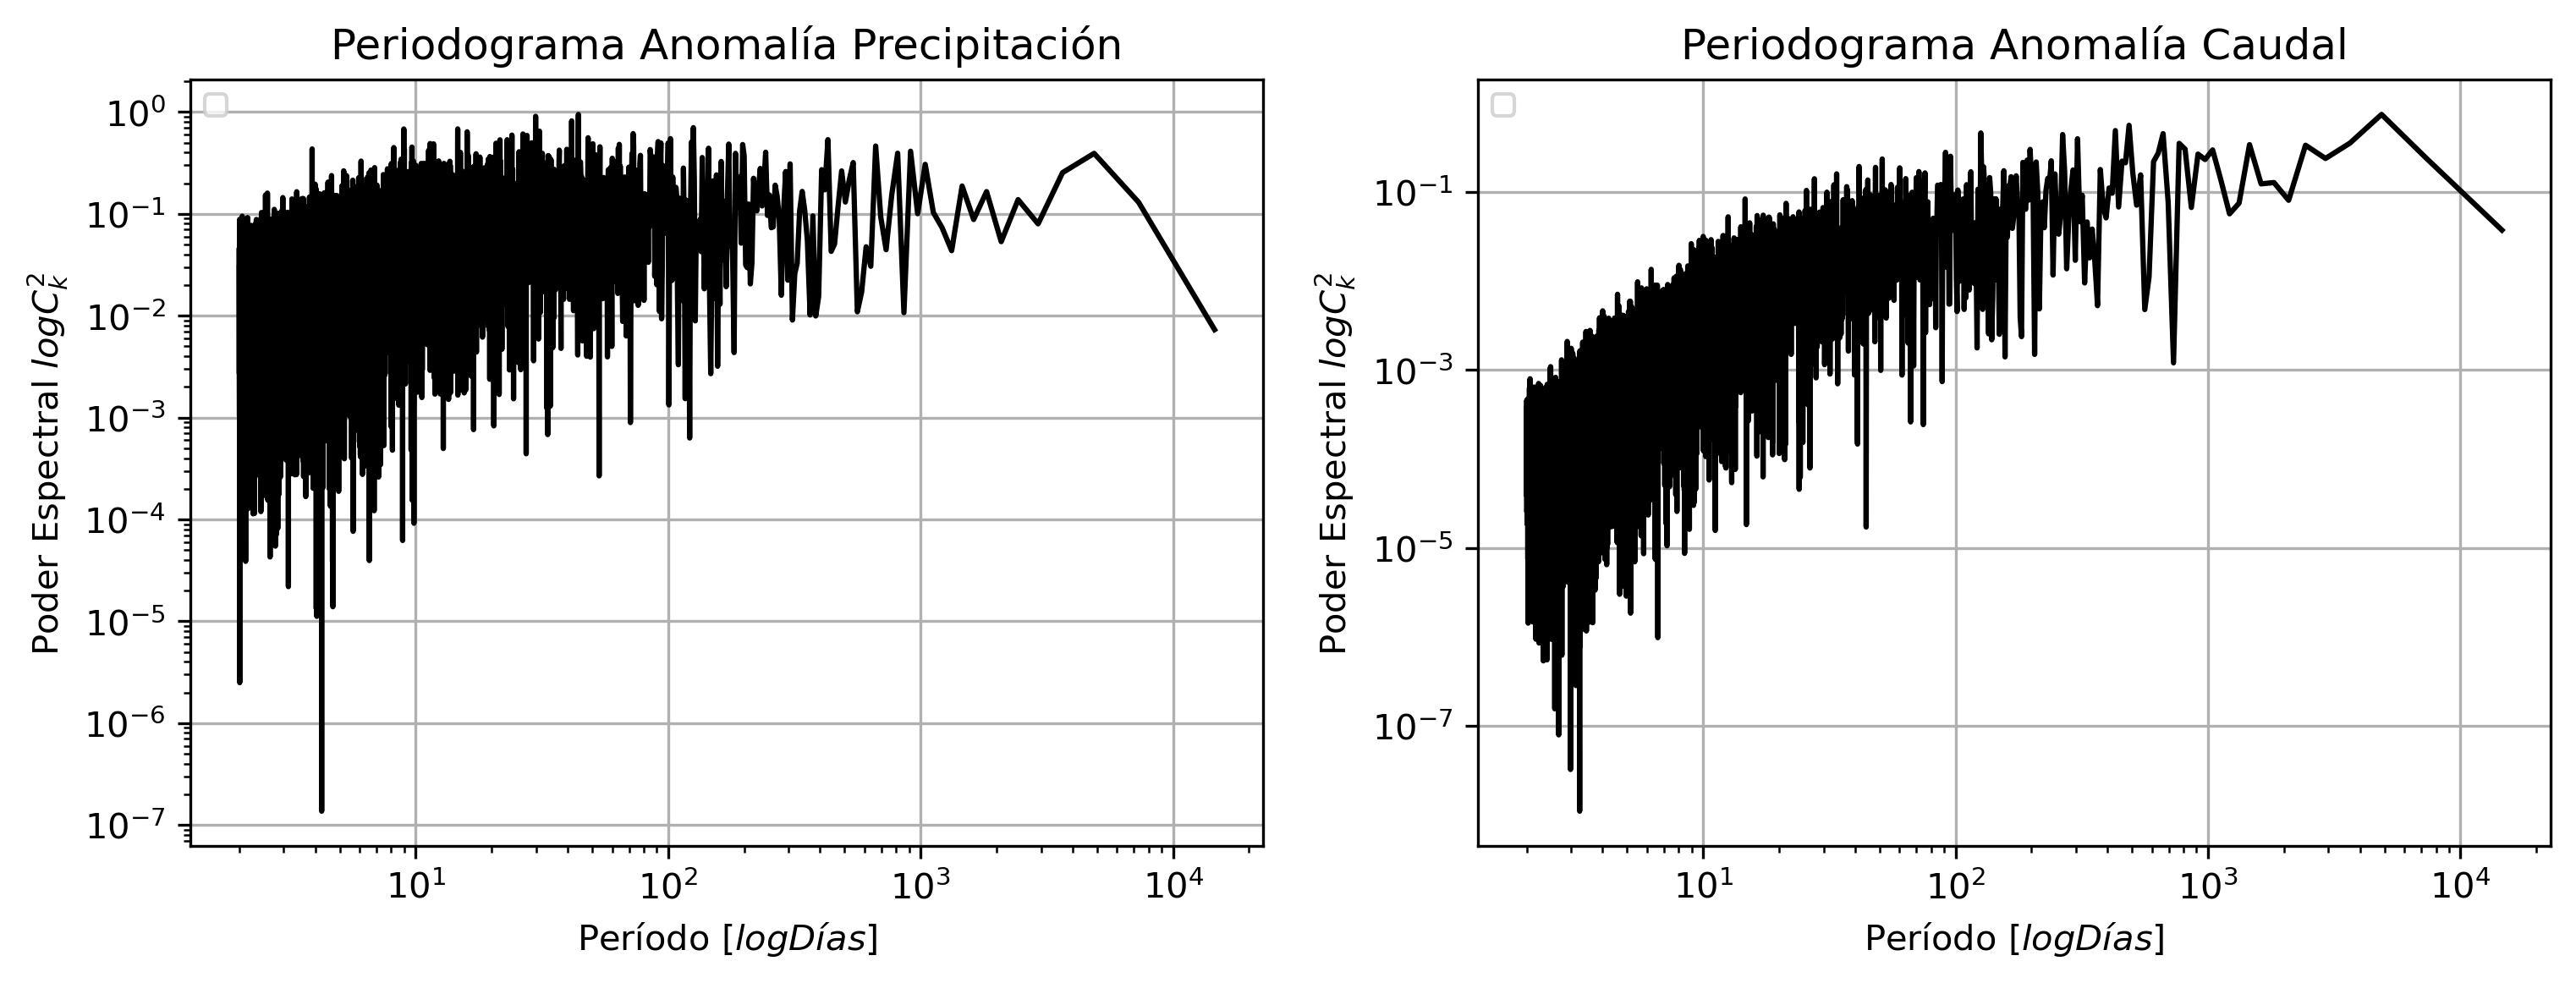

In [499]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (12,4) , dpi=300)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_ylabel('Poder Espectral $log C_{k}^{2}$')
ax1.set_xlabel('Período $[ log Días]$')
ax1.plot(t_d, C_k_pr/n_oneside, color='k' )

ax1.legend(loc=2,prop={'size': 8})
ax1.grid()
ax1.set_title('Periodograma Anomalía Precipitación', size=12)


ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_ylabel('Poder Espectral $log C_{k}^{2}$')
ax2.set_xlabel('Período $[ log Días]$')
ax2.plot(t_d, C_k_qq/n_oneside, color='k' )

ax2.legend(loc=2,prop={'size': 8})
ax2.grid()
ax2.set_title('Periodograma Anomalía Caudal', size=12)

plt.savefig('img/spectral.pdf')

plt.show()

[    0     1     2 ... 14596 14597 14598]


/var/folders/vm/k8dh5m_x4d15bk5cwzk1zk1r0000gn/T/ipykernel_50225/69262335.py:19: RuntimeWarning: divide by zero encountered in true_divide
  t_d = 1/f_oneside


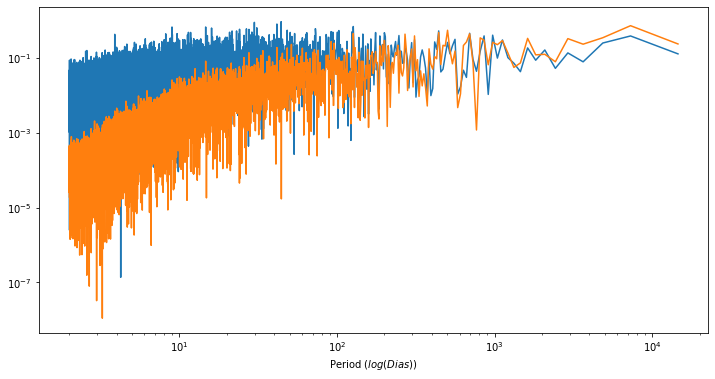

In [490]:
X_qq = fft(aqq_ar1)

X_pr = fft(apr_ar1)

N = len(X_qq)
n = np.arange(N)
print(n)
# get the sampling rate
sr = 1 
T = N/sr
freq = n/T 

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]
p_oneside = n[:n_oneside]

t_d = 1/f_oneside

plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
A_k_qq= np.abs(X_qq[:n_oneside])
C_k_qq_r= ((2/N)*(A_k_qq)**2)

A_k_pr= np.abs(X_pr[:n_oneside])
C_k_pr_r= ((2/N)*(A_k_pr)**2)

plt.plot(t_d, C_k_pr[1:len(C_k_pr)]/n_oneside - C_k_pr_r/n_oneside)
plt.plot(t_d, C_k_qq[1:len(C_k_qq)]/n_oneside - C_k_qq_r/n_oneside)

plt.xlabel('Period ($ log(Dias)$)')
plt.show()

## AR(1)

# 3. Regresion caudal y pp

## Arreglo de datos

In [332]:
df_pr = pd.read_csv('datos/precip_cr2met_mon.csv')
df_qq = pd.read_csv('datos/q_mm_mon.csv')

In [333]:
df_pr

,date,year,month,day,9414001
0,1979-01-01,1979,1,1,39.974057
1,1979-02-01,1979,2,1,22.155149
2,1979-03-01,1979,3,1,49.729685
3,1979-04-01,1979,4,1,51.183503
4,1979-05-01,1979,5,1,466.018063
...,...,...,...,...,...
499,2020-08-01,2020,8,1,NaN
500,2020-09-01,2020,9,1,NaN
501,2020-10-01,2020,10,1,NaN
502,2020-11-01,2020,11,1,NaN


In [334]:
date_serie = pd.date_range(start='1/1/1979', end='1/12/2019', freq='M')
date_serie

DatetimeIndex(['1979-01-31', '1979-02-28', '1979-03-31', '1979-04-30',
               '1979-05-31', '1979-06-30', '1979-07-31', '1979-08-31',
               '1979-09-30', '1979-10-31',
               ...
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', length=480, freq='M')

In [335]:
list(df_qq['date'])[0]

'1979-01-01'

In [336]:
start_date = '1979-01-01'
end_date = '2018-12-01'

In [337]:
list(df_pr['date']).index(start_date)

0

In [338]:
list(df_pr['date']).index(end_date)

479

In [339]:
date_qq = np.array(df_qq['date'][0:479+1])
qq = np.array(df_qq['9414001'][0:479+1])


date_pr = np.array(df_pr['date'][0:479+1])
pr = np.array(df_pr['9414001'][0:479+1])

In [340]:
print([len(pr), len(qq), len(date_serie)])

[480, 480, 480]


In [341]:
df = pd.DataFrame({'date':date_serie,
                  'pr': pr,
                  'qq': qq })

len(df)

480

## Armonico

In [342]:
qq_cicle = np.split(np.array(df['qq']), 40)
qq_cicle = np.array(qq_cicle).T

qq_cicle_mean = np.nanmean(qq_cicle, axis=1)


pr_cicle = np.split(np.array(df['pr']), 40)
pr_cicle = np.array(pr_cicle).T

pr_cicle_mean = np.nanmean(pr_cicle, axis=1)

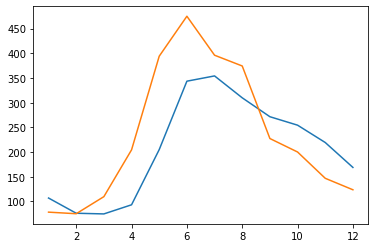

In [343]:
plt.plot(list(range(1, 13)), qq_cicle_mean)
plt.plot(list(range(1, 13)), pr_cicle_mean)

In [344]:
df.fillna(df.mean(), inplace=True)

y = df['qq']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 12)).T

regr_qq = linear_model.LinearRegression()
regr_qq.fit(X, y)

/var/folders/vm/k8dh5m_x4d15bk5cwzk1zk1r0000gn/T/ipykernel_50225/310137935.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)


LinearRegression()

In [345]:
qq_ = regr_qq.predict([armonico(x,12) for x in range(1,481)])

In [346]:
y = df['pr']

t = np.array(list(range(0, len(y))))
X = np.array(armonico(t, 12)).T

regr_pr = linear_model.LinearRegression()
regr_pr.fit(X, y)

LinearRegression()

In [347]:
pr_ = regr_pr.predict([armonico(x,12) for x in range(1,481)])

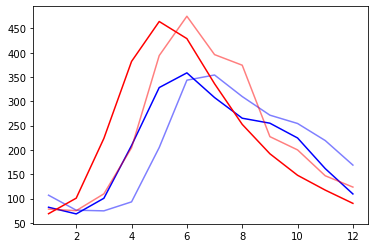

In [348]:
plt.plot(list(range(1, 13)), qq_cicle_mean, color = 'b', alpha=.5)
plt.plot(list(range(1, 13)), qq_[0:12], color = 'b')
plt.plot(list(range(1, 13)), pr_cicle_mean, color = 'r', alpha=.5)
plt.plot(list(range(1, 13)), pr_[0:12], color = 'r')

## Anomalias mensuales

In [349]:
aqq = df['qq'].values - qq_
apr = df['pr'].values - pr_

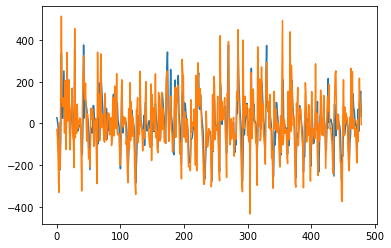

In [350]:
plt.plot(aqq)
plt.plot(apr)

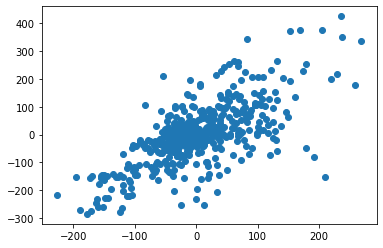

In [398]:
model1 = linear_model.LinearRegression()
X=apr
y1=aqq
model1.fit(X.reshape(-1, 1), y1)
Y_1 = model1.predict(apr.reshape(-1, 1))
plt.scatter(Y_1, y1)
r1 = np.corrcoef(Y_1, y1)[0][1]

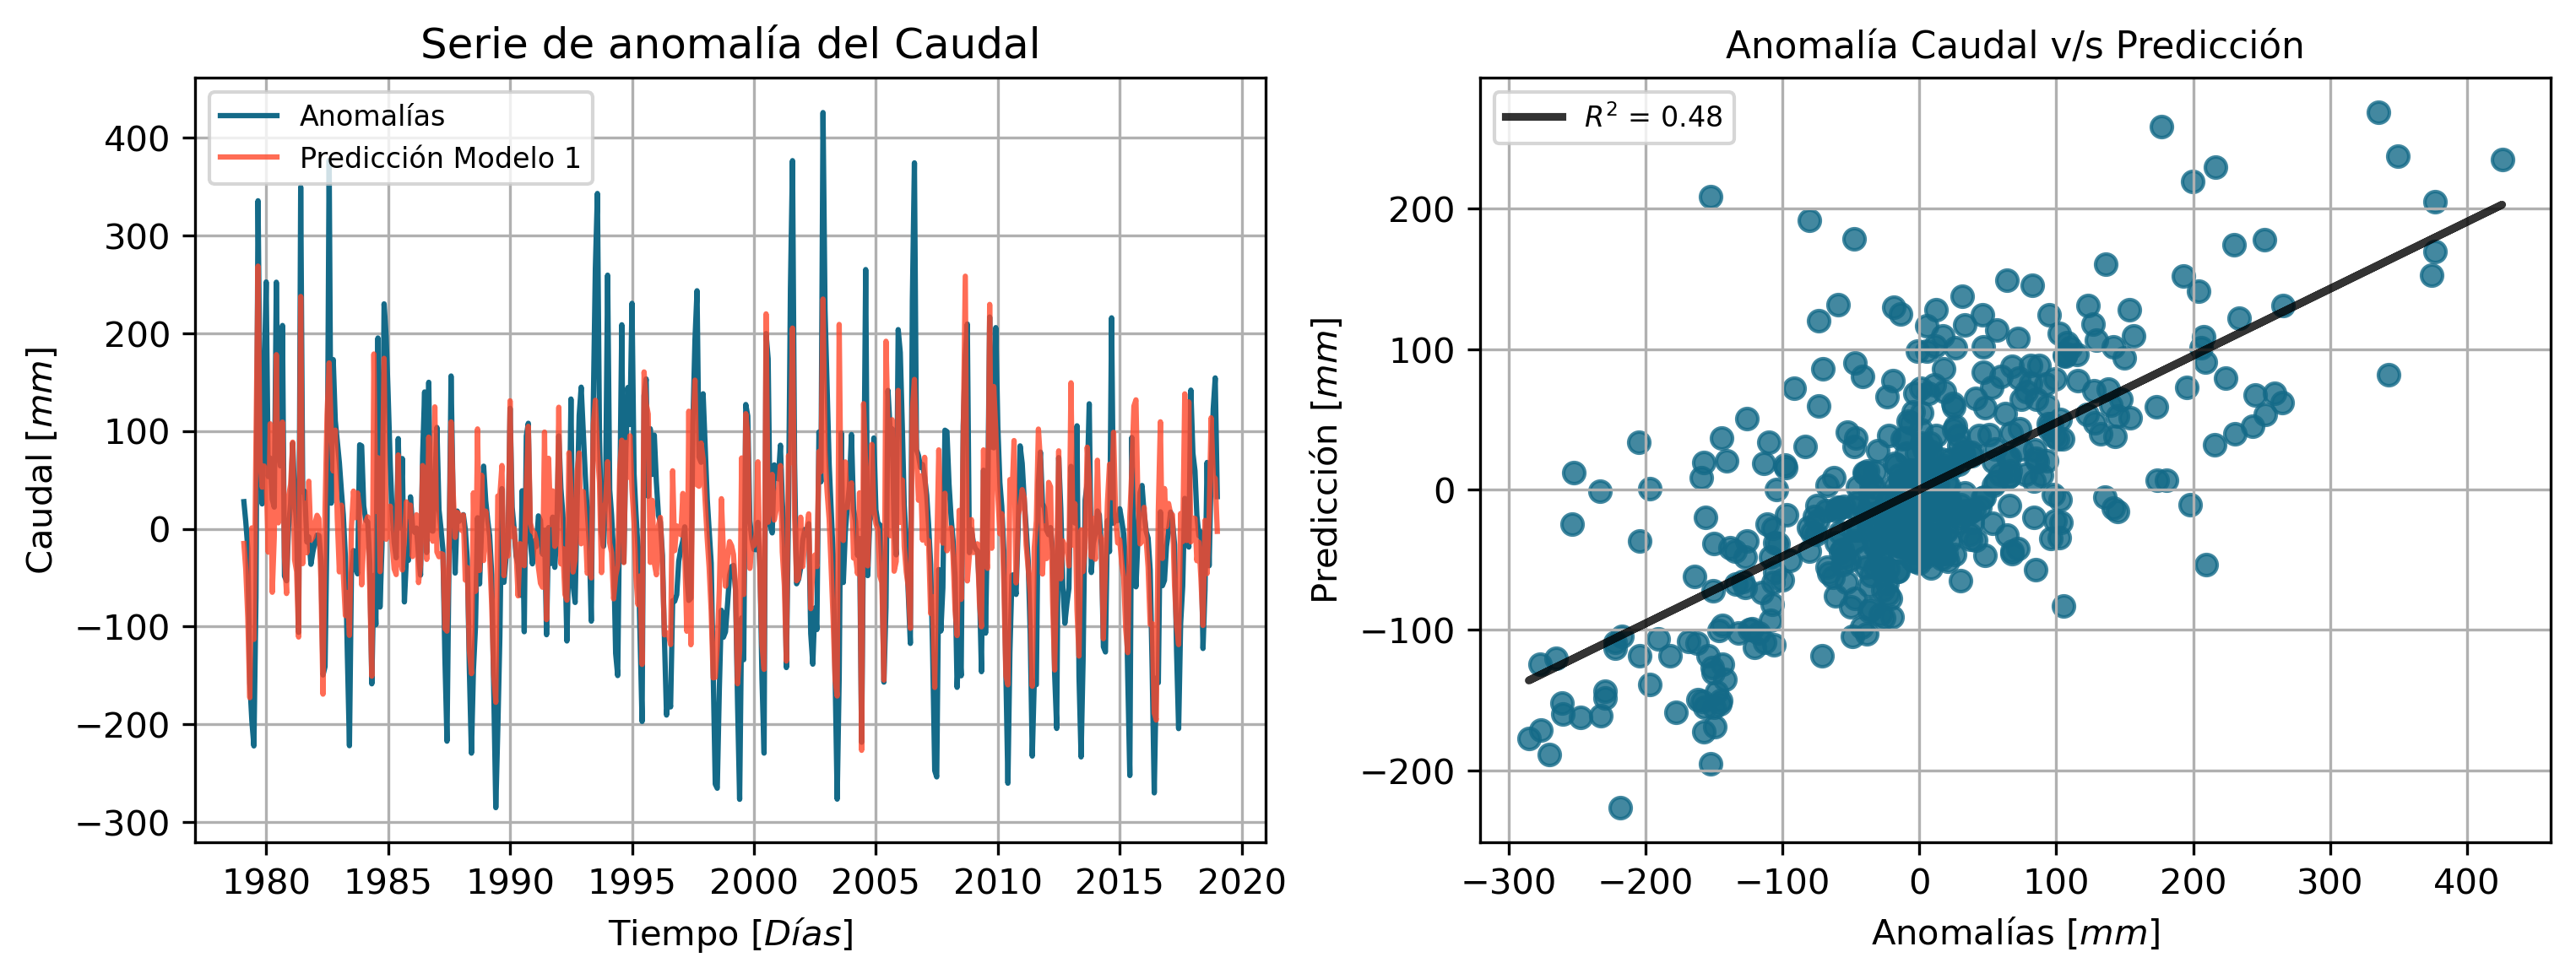

In [420]:
font = {'weight' : 'light',
        'size'   : 10}

matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (12,4) , dpi=300)

ax1.plot(df['date'], aqq, color='#146a88', label='Anomalías', alpha=1)
ax1.plot(df['date'],Y_1, color='#ff472a', label='Predicción Modelo 1', alpha=0.8)

ax1.set_ylabel('Caudal $[mm]$')
ax1.set_xlabel('Tiempo $[Días]$')

ax1.legend(loc=2,prop={'size': 8})
ax1.grid()
ax1.set_title('Serie de anomalía del Caudal', size=12)


ax2.scatter(y1, Y_1, color='#146a88', alpha= 0.8)
m, b = np.polyfit(y1, Y_1, 1)
ax2.plot(y1, m*y1 + b, color='k', alpha=0.8, linewidth=2.2, label=r'$R^{2}$ = ' + str(np.round(r1**2,2)))



ax2.set_ylabel('Predicción $[mm]$')
ax2.set_xlabel('Anomalías $[mm]$')

ax2.legend(loc=2,prop={'size': 8})
ax2.grid()
ax2.set_title('Anomalía Caudal v/s Predicción', size=10.5)

plt.savefig('img/model1.pdf')

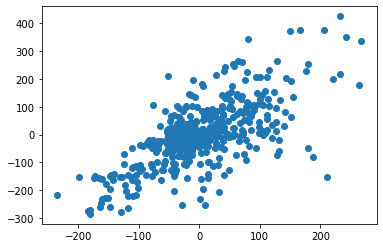

In [389]:
model2 = linear_model.LinearRegression()
X=np.array([apr[1:len(apr)], apr[0:len(apr)-1]])
y2=aqq[0:len(apr)-1]
model2.fit(X.T, y2)

Y_2 = model2.predict(X.T)
plt.scatter(Y_2, y2)
r2 = np.corrcoef(Y_2, y2)[0][1]

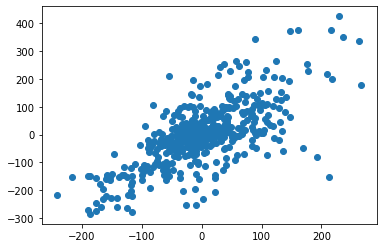

In [390]:
model3 = linear_model.LinearRegression()
X=np.array([apr[2:len(apr)], apr[1:len(apr)-1], apr[0:len(apr)-2]])
y3=aqq[0:len(apr)-2]
model3.fit(X.T, y3)

Y_3 = model3.predict(X.T)
plt.scatter(Y_3, y3)
r3 = np.corrcoef(Y_3, y3)[0][1]

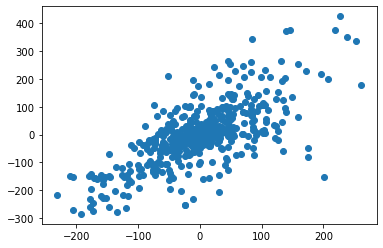

In [391]:
model4 = linear_model.LinearRegression()
X=np.array([apr[3:len(apr)], apr[2:len(apr)-1], apr[1:len(apr)-2], apr[0:len(apr)-3]])
y4=aqq[0:len(apr)-3]
model4.fit(X.T, y4)

Y_4 = model4.predict(X.T)
plt.scatter(Y_4, y4)
r4 = np.corrcoef(Y_4, y4)[0][1]

In [392]:
rs = []
for i in tq(range(1, 300)):
    X=[]
    for j in range(0, i):
        X.append(apr[j:len(apr)-(i-j)])
    model = linear_model.LinearRegression()    
    X=np.array(X)
    y=aqq[0:len(apr)-i]
    model.fit(X.T, y)

    Y_ = model.predict(X.T)
    rs.append(np.corrcoef(Y_, y)[0][1]**2)
        
        

100%|████████████████████████████████████████| 299/299 [00:01<00:00, 256.28it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


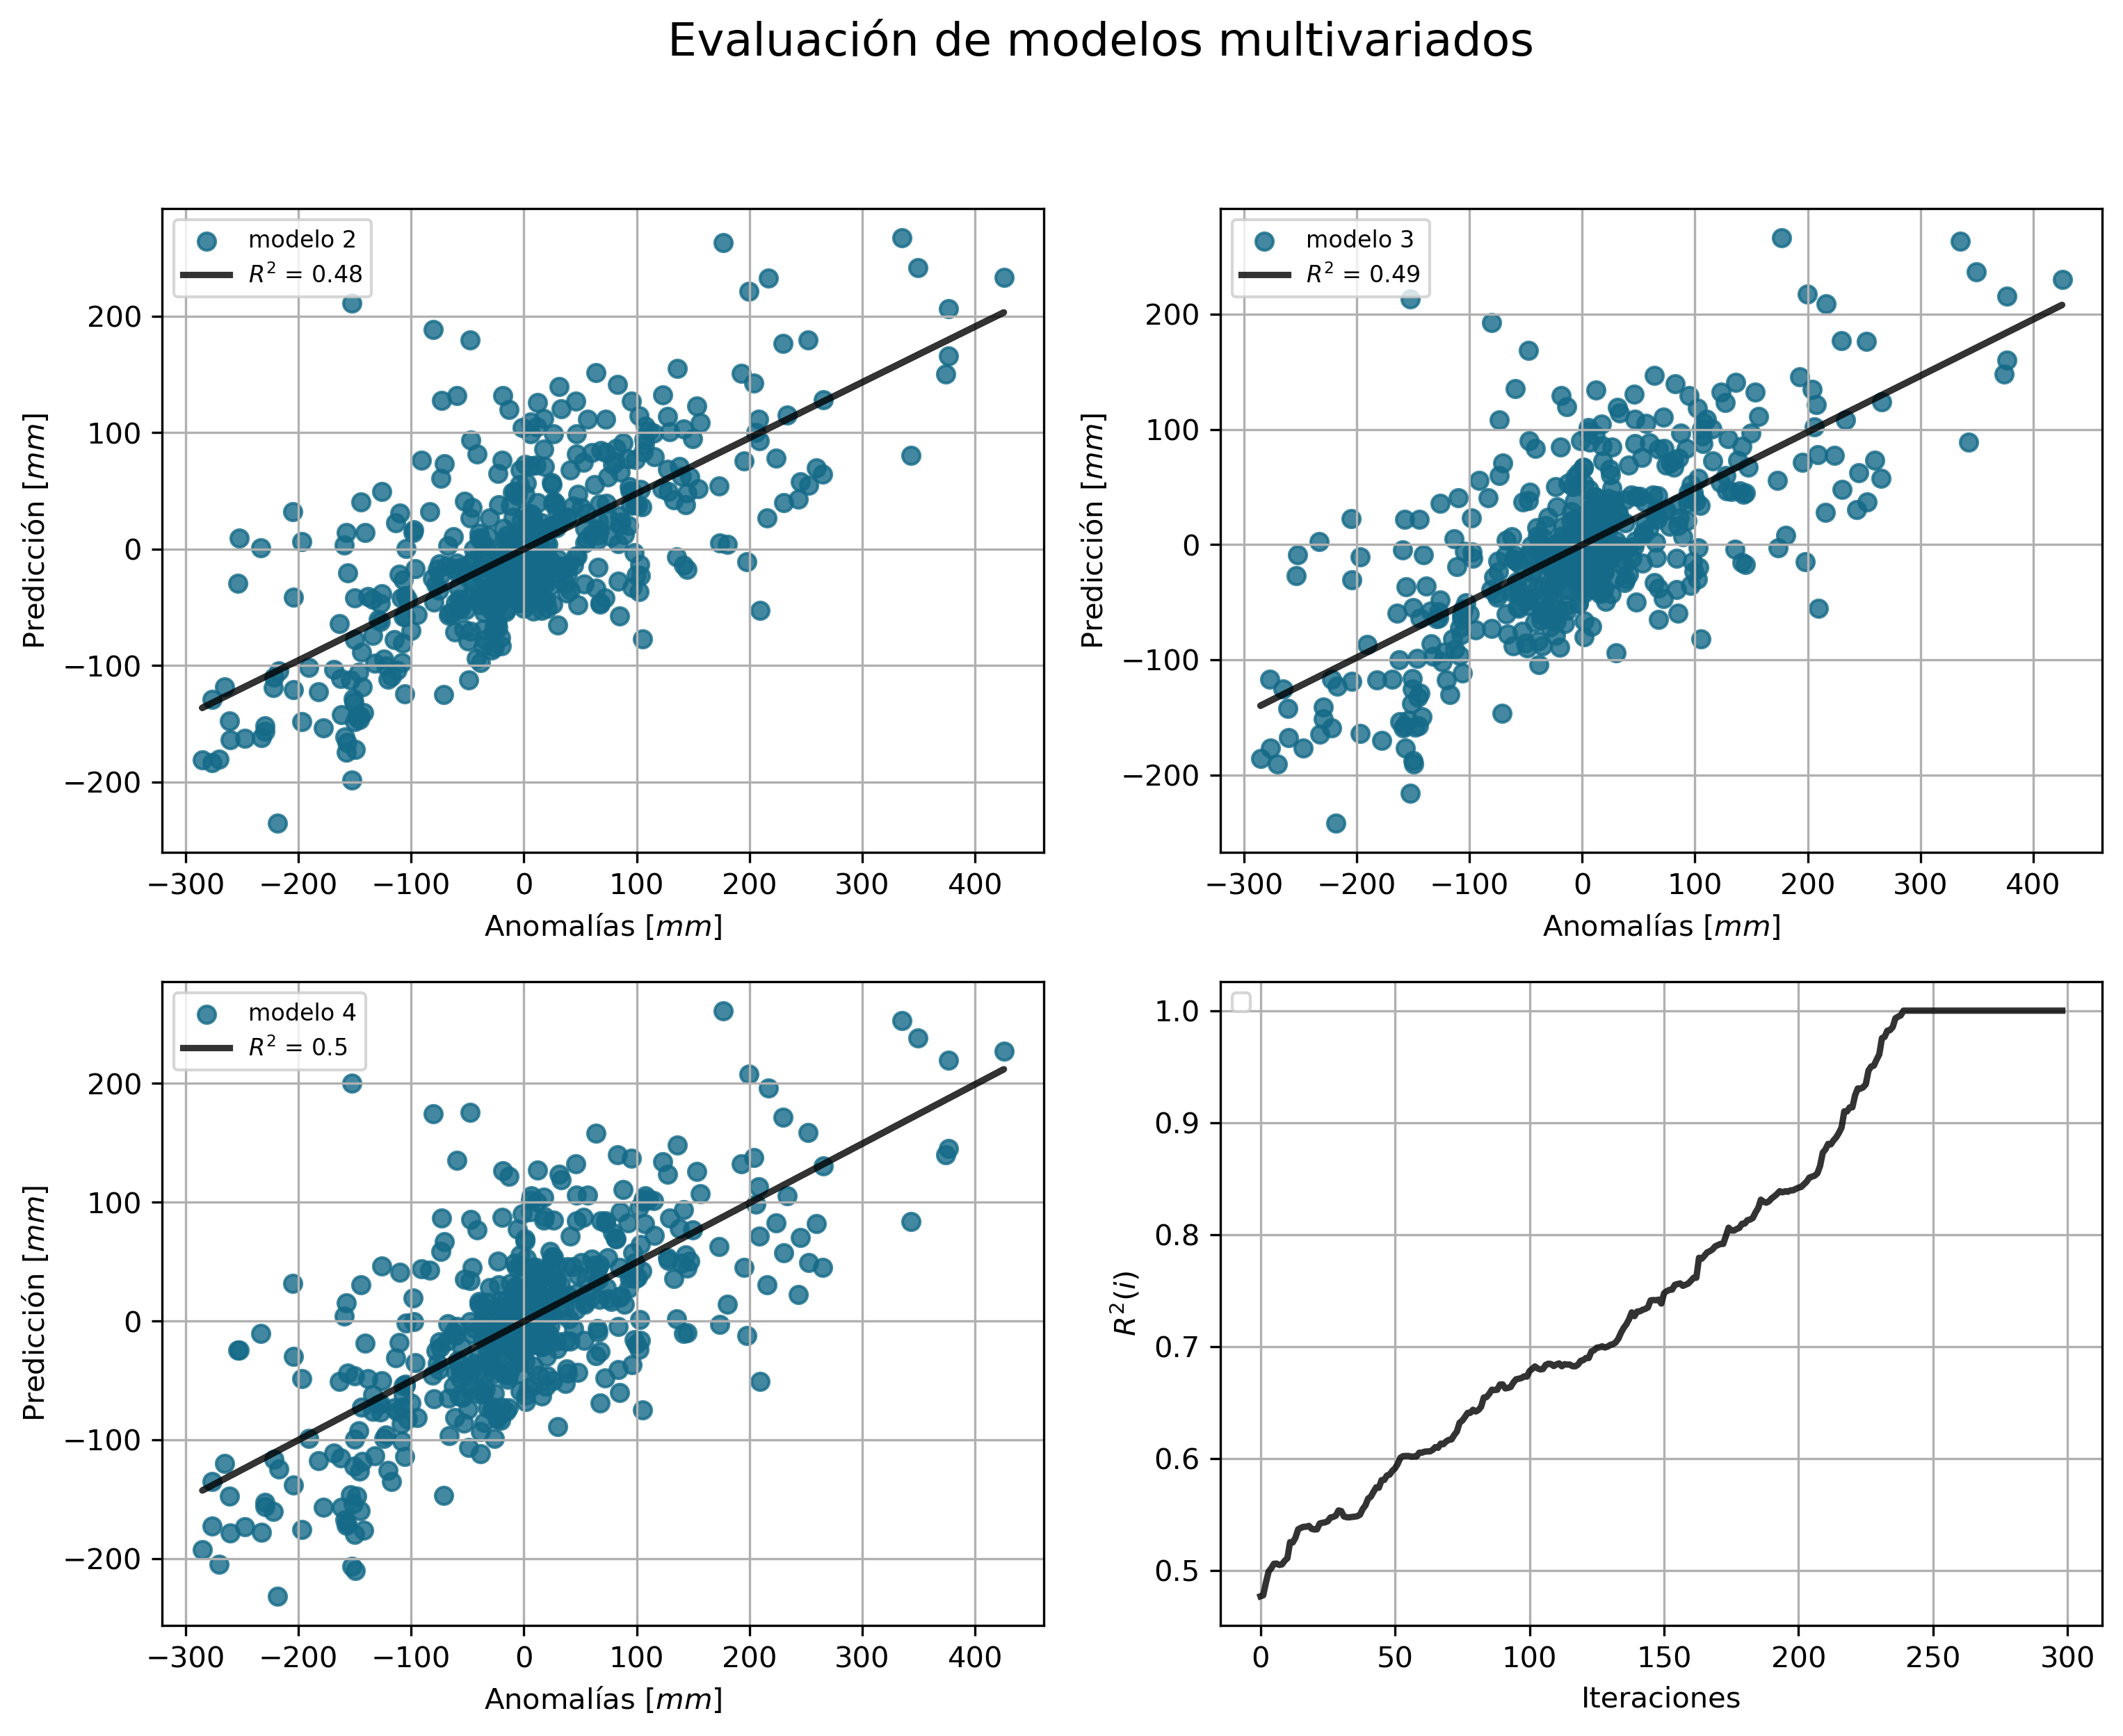

In [419]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize= (12,9) , dpi=300)


fig.suptitle('Evaluación de modelos multivariados', fontsize=16)

ax1.scatter(y2, Y_2, color='#146a88', alpha= 0.8, label='modelo 2')
m, b = np.polyfit(y2, Y_2, 1)
ax1.plot(y2, m*y2 + b, color='k', alpha=0.8, linewidth=2.2, label=r'$R^{2}$ = ' + str(np.round(r2**2,2)))

ax1.set_ylabel('Predicción $[mm]$')
ax1.set_xlabel('Anomalías $[mm]$')
ax1.legend(loc=2,prop={'size': 8})
ax1.grid()



ax2.scatter(y3, Y_3, color='#146a88', alpha= 0.8, label='modelo 3')
m, b = np.polyfit(y3, Y_3, 1)
ax2.plot(y3, m*y3 + b, color='k', alpha=0.8, linewidth=2.2, label=r'$R^{2}$ = ' + str(np.round(r3**2,2)))

ax2.set_ylabel('Predicción $[mm]$')
ax2.set_xlabel('Anomalías $[mm]$')
ax2.legend(loc=2,prop={'size': 8})
ax2.grid()


ax3.scatter(y4, Y_4, color='#146a88', alpha= 0.8, label='modelo 4')
m, b = np.polyfit(y4, Y_4, 1)
ax3.plot(y4, m*y4 + b, color='k', alpha=0.8, linewidth=2.2, label=r'$R^{2}$ = ' + str(np.round(r4**2,2)))

ax3.set_ylabel('Predicción $[mm]$')
ax3.set_xlabel('Anomalías $[mm]$')
ax3.legend(loc=2,prop={'size': 8})
ax3.grid()


ax4.plot(np.arange(len(rs)), rs, color='k', alpha=0.8, linewidth=2.2)

ax4.set_ylabel('$R^{2}(i)$')
ax4.set_xlabel('Iteraciones')
ax4.legend(loc=2,prop={'size': 8})
ax4.grid()

plt.savefig('img/model234.pdf')

# 4. Rergesiones para cada mes

In [424]:
aqq_ = np.array(np.split(aqq, 40)).T
np.shape(aqq_)

(12, 40)

In [425]:
apr_ = np.array(np.split(apr, 40)).T
np.shape(apr_)

(12, 40)

In [426]:
rs=[]
for i in tq(range(0,12)):
    v=apr_[i]
    model4 = linear_model.LinearRegression()
    X=np.array([v[3:len(v)], v[2:len(v)-1], v[1:len(v)-2], v[0:len(v)-3]])
    y4=aqq_[i][0:40-3]
    model4.fit(X.T, y4)

    Y_4 = model4.predict(X.T)
    rs.append(np.corrcoef(Y_4, y4)[0][1]**2)
    

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 786.27it/s]


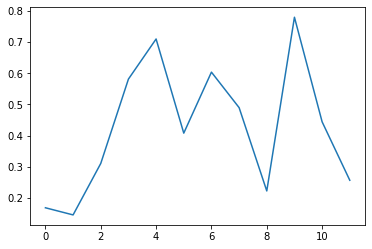

In [427]:
plt.plot(rs)

In [434]:
meses = ['Jan', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']

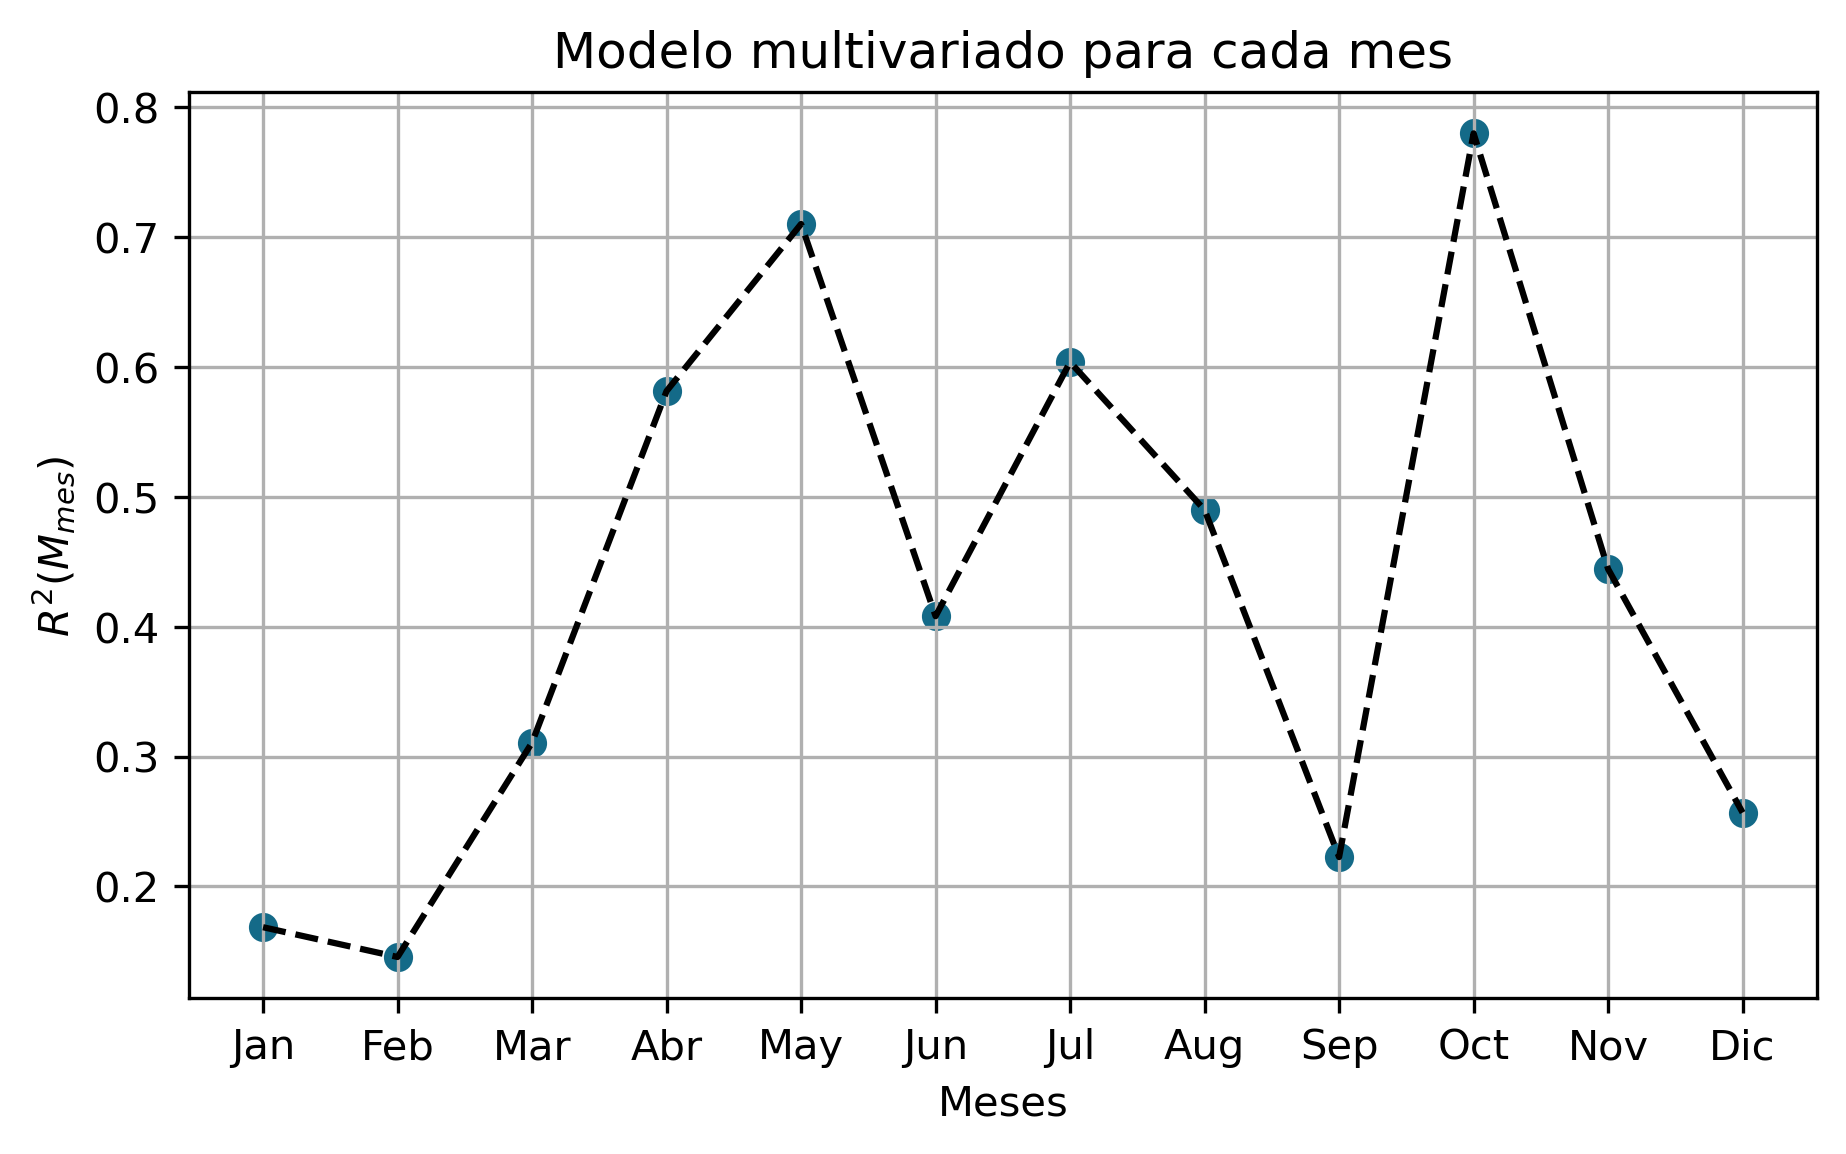

In [442]:
fig = plt.figure(figsize= (7,4) , dpi=300)



plt.plot(meses, rs,
       '--', color = 'k')

plt.scatter(meses, rs, color = '#146a88')
plt.xlabel('Meses')
plt.ylabel('$R^{2}(M_{mes})$')
           
plt.grid()


plt.title('Modelo multivariado para cada mes')


plt.savefig('img/modelomeses.pdf')